# CelebA Binary Classification
We will be performing binary classification on the CelebA dataset. As the CelebA dataset has ~200k images, we will use a subset of 16k images for training to speed up the trainign process. The two classes in the dataset are:
* Class 0: Not Smiling
* Class 1: Smiling

## 1. Setup

In [40]:
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt 

In [18]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print('Using device:', device)

Using device: mps


In [19]:
# Download dataset
image_path = './data' 
train_dataset = torchvision.datasets.CelebA(image_path, split='train', download=True)
valid_dataset = torchvision.datasets.CelebA(image_path, split='valid', download=True)
test_dataset = torchvision.datasets.CelebA(image_path, split='test', download=True)

# Check the size of the dataset
print('Number of training images: ', len(train_dataset))
print('Number of validation images: ', len(valid_dataset))
print('Number of testing images: ', len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Number of training images:  162770
Number of validation images:  19867
Number of testing images:  19962


## 2. Image Preprocessing

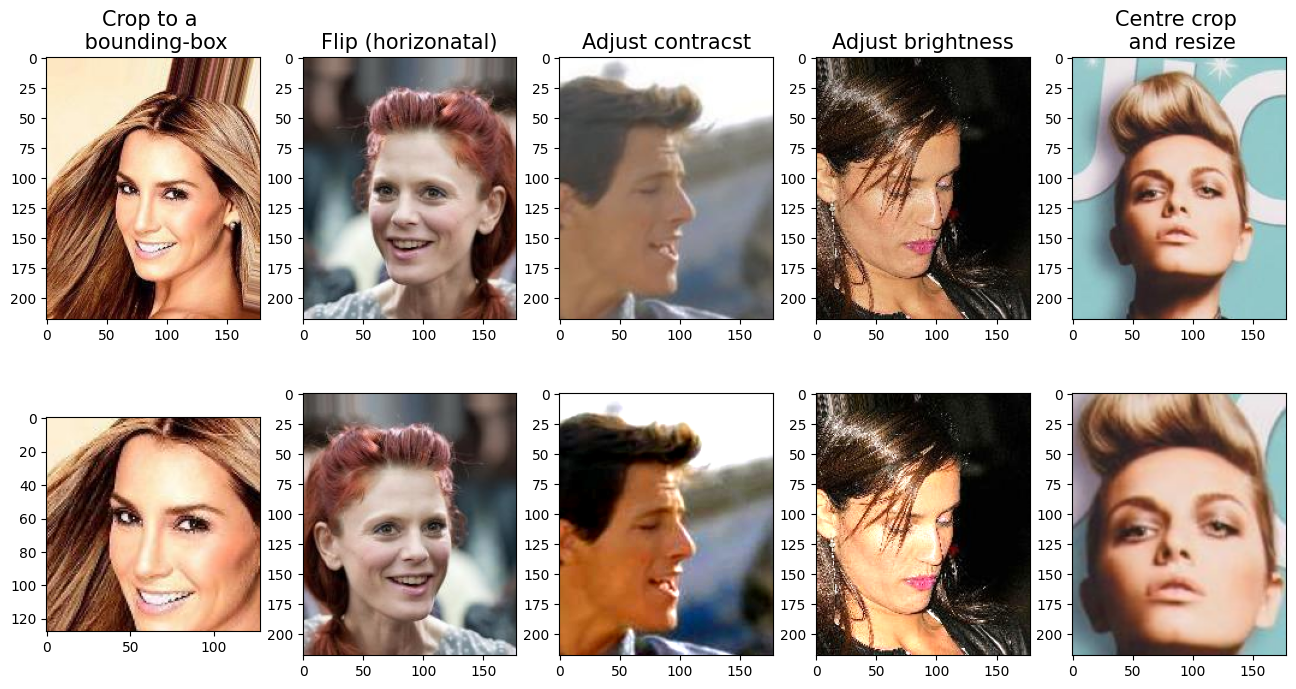

In [20]:
# Explore various forms of data augmentation
fig = plt.figure(figsize=(16, 8))

## Column 1: Cropping to a bounding box 
ax = fig.add_subplot(2, 5, 1)
img, attr = train_dataset[0]
ax.set_title('Crop to a \n bounding-box', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 6)
img_cropped = transforms.functional.crop(img, 50, 20, 128, 128)
ax.imshow(img_cropped)

## Column 2: Flipping horizonally
ax = fig.add_subplot(2, 5, 2)
img, attr = train_dataset[1]
ax.set_title('Flip (horizonatal)', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 7)
img_flipped = transforms.functional.hflip(img)
ax.imshow(img_flipped)

## Column 3: Adjust contrast
ax = fig.add_subplot(2, 5, 3)
img, attr = train_dataset[2]
ax.set_title('Adjust contracst', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 8)
img_adj_contrast = transforms.functional.adjust_contrast(img, 2)
ax.imshow(img_adj_contrast)

## Column 4: Adjust brightness
ax = fig.add_subplot(2, 5, 4)
img, attr = train_dataset[3]
ax.set_title('Adjust brightness', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 9)
img_adj_brightness = transforms.functional.adjust_brightness(img, 1.3)
ax.imshow(img_adj_brightness)

## Column 5: Crop from image center and resize
ax = fig.add_subplot(2, 5, 5)
img, attr = train_dataset[4]
ax.set_title('Centre crop \n and resize', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 10)
img_center_cropped = transforms.functional.center_crop(img, [0.7*218, 0.7*178])
img_resize = transforms.functional.resize(img_center_cropped, [218, 178])
ax.imshow(img_resize);

In [30]:
# Define a function to extract the smile attribute
get_smile = lambda attr: attr[18]

# Define data augmentation to train dataset
transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

# Define transformation to validation and test datasets
transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

# Load the dataset with transformation
train_dataset = torchvision.datasets.CelebA(image_path, split='train', download=True, transform=transform_train, target_transform=get_smile)
valid_dataset = torchvision.datasets.CelebA(image_path, split='valid', download=True, transform=transform, target_transform=get_smile)
test_dataset = torchvision.datasets.CelebA(image_path, split='test', download=True, transform=transform, target_transform=get_smile)

# Load Subset of the dataset
train_dataset = Subset(train_dataset, torch.arange(16000))
valid_dataset = Subset(valid_dataset, torch.arange(1000))
test_dataset = Subset(test_dataset, torch.arange(1000))

print('Number of training images: ', len(train_dataset))
print('Number of validation images: ', len(valid_dataset))
print('Number of testing images: ', len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Number of training images:  16000
Number of validation images:  1000
Number of testing images:  1000


In [31]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 3. Model Training

In [33]:
# Define the model
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Input: 3x64x64, Output: 32x64x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 32x32x32
            nn.Dropout(0.5),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output: 64x32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 64x16x16
            nn.Dropout(0.5),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # Output: 128x16x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 128x8x8
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), # Output: 256x8x8
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=8), # Output: 256x1x1
            nn.Flatten(), # Output: 256
            nn.Linear(256, 1), # Output: 1
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.sequential(x)

In [37]:
# Instantiate the model
model = ConvNet()

# Define loss function
loss_fn = nn.BCELoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define a function to train the model
def train(model, num_epochs, train_dataloader, valid_dataloader):
    # Initialize history tracking
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        # Train the model
        model.train()
        for image, label in train_dataloader:
            pred = model(image)[:,0]
            loss = loss_fn(pred, label.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*label.size(0)
            is_correct = ((pred > 0.5).float() == label).float().sum()
            accuracy_hist_train[epoch] += is_correct
        loss_hist_train[epoch] /= len(train_dataloader.dataset)
        accuracy_hist_train[epoch] /= len(train_dataloader.dataset)

        # Validate the model
        model.eval()
        with torch.no_grad():
            for image, label in valid_dataloader:
                pred = model(image)[:,0]
                loss = loss_fn(pred, label.float())
                loss_hist_valid[epoch] += loss.item()*label.size(0)
                is_correct = ((pred > 0.5).float() == label).float().sum()
                accuracy_hist_valid[epoch] += is_correct
            loss_hist_valid[epoch] /= len(valid_dataloader.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dataloader.dataset)

        print(f"Epoch {epoch + 1} accuracy: "
              f"train={accuracy_hist_train[epoch]:.4f}, "
              f"valid={accuracy_hist_valid[epoch]:.4f}")
    
    return loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid

In [38]:
# Train the model
epochs = 30

hist = train(model, epochs, train_loader, valid_loader)

Epoch 1 accuracy: train=0.6162, valid=0.6590
Epoch 2 accuracy: train=0.6934, valid=0.7370
Epoch 3 accuracy: train=0.7143, valid=0.7650
Epoch 4 accuracy: train=0.7267, valid=0.7480
Epoch 5 accuracy: train=0.7431, valid=0.7740
Epoch 6 accuracy: train=0.7483, valid=0.7800
Epoch 7 accuracy: train=0.7615, valid=0.7820
Epoch 8 accuracy: train=0.7682, valid=0.7950
Epoch 9 accuracy: train=0.7746, valid=0.7980
Epoch 10 accuracy: train=0.7823, valid=0.8030
Epoch 11 accuracy: train=0.7896, valid=0.8060
Epoch 12 accuracy: train=0.8043, valid=0.8180
Epoch 13 accuracy: train=0.8176, valid=0.8370
Epoch 14 accuracy: train=0.8333, valid=0.8400
Epoch 15 accuracy: train=0.8336, valid=0.8400
Epoch 16 accuracy: train=0.8371, valid=0.8450
Epoch 17 accuracy: train=0.8474, valid=0.8610
Epoch 18 accuracy: train=0.8489, valid=0.8550
Epoch 19 accuracy: train=0.8551, valid=0.8590
Epoch 20 accuracy: train=0.8549, valid=0.8690
Epoch 21 accuracy: train=0.8583, valid=0.8700
Epoch 22 accuracy: train=0.8584, valid=0.86

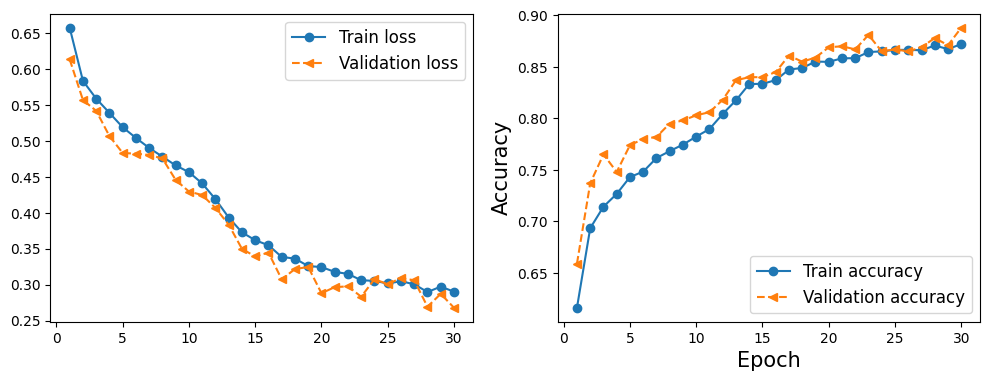

In [43]:
# Visualize the results
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[2], '--<', label='Validation loss')
ax.legend(fontsize=12)
#ax.set_xlabel('Epoch', size=15)
#ax.set_ylabel('Loss', size=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[1], '-o', label='Train accuracy')
ax.plot(x_arr, hist[3], '--<', label='Validation accuracy')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15);

## 4. Model Evaluation

In [41]:
# Calculate test accuracy
accuracy_test = 0
model.eval()
with torch.no_grad():
    for image, label in test_loader:
        pred = model(image)[:,0]
        is_correct = ((pred > 0.5).float() == label).float().sum()
        accuracy_test += is_correct
accuracy_test /= len(test_loader.dataset)
print(f"Test accuracy: {accuracy_test:.4f}")

Test accuracy: 0.8990
